## **1. Import Libraries**

In [2]:
# Baisc Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
import joblib
import pickle

import os
from pathlib import Path
import glob
from tqdm import tqdm
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

# Text processing Libraries
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from string import punctuation 
from wordcloud import WordCloud, STOPWORDS
!pip install thefuzz
from thefuzz import fuzz
# from distance import distance

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
# !pip install xgboost-gpu

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, concatenate, LSTM, Dense, BatchNormalization, Dropout
from keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##**2. Load Dataset**

In [3]:
# mounting the drive
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [4]:
# change directory
%cd /content/drive/MyDrive/Colab\ Notebooks/ML_CaseStudies/1_Quora/

/content/drive/MyDrive/Colab Notebooks/ML_CaseStudies/1_Quora


In [4]:
# # load the train and test data frames with customised features from parquet file

dir_name = "data/"
x_train_features  = pd.read_parquet(dir_name+'x_train_features.parquet')
x_test_features = pd.read_parquet(dir_name+'x_test_features.parquet')
y_train = pd.read_parquet(dir_name+'y_train.parquet')
y_test = pd.read_parquet(dir_name+'y_test.parquet')

In [ ]:
x_train_features.shape

(303217, 28)

In [ ]:
x_train_features.head()

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,freq_q1+q2,q1len,q2len,q1_n_words,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio
179028,274801,274802,mani state anthem india,india chang nation anthem speak manipur state,1,1,0,47,91,9,...,0.222220,0.124999,0.0,0.0,7.0,12.5,19,47,55,46
155911,244152,244153,futur app,futur app,1,1,0,20,26,4,...,0.749981,0.499992,1.0,1.0,2.0,5.0,78,70,89,70
51688,91649,91650,best weekend mba program india,everyon love ciel phantomh sebastian,1,1,0,48,48,9,...,0.000000,0.000000,0.0,0.0,2.0,8.0,29,36,12,12
273097,391494,176735,eat tomato sauc pasta paleo diet carb pasta co...,best sauc spinach pasta,1,2,1,127,52,26,...,0.181817,0.080000,0.0,0.0,14.0,18.0,26,44,49,42
281356,401118,401119,key west fl miami fl compar,key west fl miami fl differ,1,1,0,39,38,9,...,0.777769,0.777769,0.0,1.0,0.0,9.0,86,87,89,86


## **3. TF-IDF weighted WORD2VEC** Using Pretrained Models

In [ ]:
# combining the question1 and question2 text
x_train_features["question_text"] = x_train_features["question1"] + x_train_features["question2"]
x_test_features["question_text"] = x_test_features["question1"] + x_test_features["question2"]

In [ ]:
# load the glove vectors from the text file
# create a dictionary with keys:words and values:vectors

file = "../glove/glove.6B.100d.txt"

from collections import defaultdict
with open(file) as f:
    embeddings_dict = dict()
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_dict[word] = coefs

glove_words = set(embeddings_dict.keys())
print('Loaded %s word vectors of dimension 100' % len(embeddings_dict))

Loaded 400000 word vectors of dimension 100


In [ ]:
# using tfidf vectorizer to extract the idf values

tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train_features["question_text"])

# we convert into dictionary of key:word and value: idf_value
idf_dict = dict(zip(tfidf_model.get_feature_names_out(), tfidf_model.idf_))

idf_words = set(tfidf_model.get_feature_names_out())

In [ ]:
def tfidf_word2vec(texts_list):
    """
        Custom function to create average tfidf weighted word_vectors
        input: list of texts
        ouput: list of word vectors ==> each 1D array of shape (100,1)
    """

    text_vectors_list = []

    for text in tqdm(texts_list):

        text_vector = np.zeros(100)
        tf_idf_weight = 0

        for word in text.split():

            if (word in idf_words) and (word in glove_words):

                # load the word vector from glove embedding dictionary
                glove_vector = embeddings_dict.get(word)

                # tfidf =  tf * idf
                tf = text.count(word)/len(text.split())
                tfidf = idf_dict.get(word) * tf

                word_vector = glove_vector * tfidf

                text_vector += word_vector
                tf_idf_weight += tfidf

            # to compute the average word_vector over each particular text
            if tf_idf_weight != 0:
                text_vector /= tf_idf_weight

        text_vectors_list.append(text_vector)

    return text_vectors_list

In [ ]:
# convert 'question_text" into tf-idf weighted word vectors

x_train_tfw2v = tfidf_word2vec(x_train_features['question_text'])
x_test_tfw2v = tfidf_word2vec(x_test_features['question_text'])

100%|██████████| 101073/101073 [00:11<00:00, 9060.21it/s]


In [ ]:
# save the tf-idf weighted word vectors in a data frame

df_x_train_tfw2v = pd.DataFrame(x_train_tfw2v, index = x_train_features.index, columns = [str(i) for i in range(len(x_train_tfw2v[0]))])
df_x_test_tfw2v = pd.DataFrame(x_test_tfw2v, index = x_test_features.index, columns = [str(i) for i in range(len(x_test_tfw2v[0]))])

In [ ]:
df_x_train_tfw2v.shape

(303217, 100)

In [ ]:
df_x_train_tfw2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
179028,-0.003764,-0.021516,0.153426,-0.042538,0.005305,0.052209,-0.051582,0.122951,-0.043960,0.022401,...,0.031149,-0.094567,-0.148981,0.046114,-0.166839,0.036640,0.050088,-0.029701,0.101749,-0.057369
155911,-0.272817,-0.292175,0.170802,-0.260829,0.242072,-0.041941,0.164062,-0.035295,0.617796,0.072412,...,0.405848,0.609659,0.011084,-0.173908,0.106483,0.032097,0.138533,-0.128966,0.678453,0.014884
51688,0.061110,-0.032670,-0.050448,-0.181467,0.121050,0.180000,0.097370,0.007137,-0.160556,-0.133778,...,-0.107514,-0.046235,-0.042478,0.071393,-0.132688,0.224614,0.041589,-0.092891,-0.127575,-0.014526
273097,-0.115669,0.180347,-0.102419,0.024695,-0.049825,-0.050338,0.275648,0.055547,0.042651,0.082580,...,0.002600,0.084035,-0.045179,-0.100926,-0.077635,-0.126955,0.044914,-0.057398,0.145011,0.143053
281356,-0.012848,0.011422,0.015132,0.006648,-0.007147,0.003864,0.005464,-0.011000,0.001508,0.001818,...,-0.009867,-0.000587,-0.005162,-0.008698,-0.009262,-0.003261,-0.013357,-0.012595,0.015378,-0.002273


In [ ]:
x_train_features.shape

(303217, 29)

In [ ]:
# drop the unneccesary features to get the data frames model-ready

x_train_ml = x_train_features.drop(['qid1','qid2','question1','question2', 'question_text'],axis=1)
x_test_ml = x_test_features.drop(['qid1','qid2','question1','question2', 'question_text'],axis=1)

In [ ]:
x_train_ml.shape

(303217, 24)

In [ ]:
# concatenate the word-vector columns to the dataframe with custom-features

x_train_ml  = pd.concat([x_train_ml ,df_x_train_tfw2v] , axis = 'columns')
x_test_ml  = pd.concat([x_test_ml, df_x_test_tfw2v] , axis = 'columns')

In [ ]:
x_train_ml.shape

(303217, 124)

In [ ]:
x_train_ml.head()

,freq_qid1,freq_qid2,freq_q1+q2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,...,90,91,92,93,94,95,96,97,98,99
179028,1,1,0,47,91,9,16,2.0,25.0,0.080000,...,0.031149,-0.094567,-0.148981,0.046114,-0.166839,0.036640,0.050088,-0.029701,0.101749,-0.057369
155911,1,1,0,20,26,4,6,3.0,10.0,0.300000,...,0.405848,0.609659,0.011084,-0.173908,0.106483,0.032097,0.138533,-0.128966,0.678453,0.014884
51688,1,1,0,48,48,9,7,0.0,16.0,0.000000,...,-0.107514,-0.046235,-0.042478,0.071393,-0.132688,0.224614,0.041589,-0.092891,-0.127575,-0.014526
273097,1,2,1,127,52,26,11,2.0,29.0,0.068966,...,0.002600,0.084035,-0.045179,-0.100926,-0.077635,-0.126955,0.044914,-0.057398,0.145011,0.143053
281356,1,1,0,39,38,9,9,7.0,16.0,0.437500,...,-0.009867,-0.000587,-0.005162,-0.008698,-0.009262,-0.003261,-0.013357,-0.012595,0.015378,-0.002273


## **4. ML MODELS**

### **Making data model ready**

In [5]:
# # save the train and test data frame into parquet file and load back
files_list = ['x_train_ml.parquet',
              'x_test_ml.parquet',
              'y_train.parquet',
              'y_test.parquet']

dirname = "data/"

for file_name in files_list:
    if not os.path.isfile(dirname+file_name):
        # to convert the file_name from string format to variable format we use vars() method
        # Ref: https://thecodingbot.com/use-string-value-as-a-variable-name-in-python/
        vars()[file_name.split(".")[0]].to_parquet(dirname+file_name)
    else:
        vars()[file_name.split(".")[0]] = pd.read_parquet(dirname+file_name)

In [6]:
# column standardizing the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train_ml)
x_train = scaler.transform(x_train_ml)
x_test = scaler.transform(x_test_ml)

### **4.0 Functions**

In [8]:
def heatmp_mat(M, name, ax):
    """ This function represents confusion matrix in heatmap format """

    labels = [0,1]
    cmap =sns.light_palette("blue") #"YlGnBu"
    sns.heatmap(M, annot=True,  fmt=".3f", cmap = cmap, xticklabels=labels, yticklabels=labels, ax =ax)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Original Class')
    ax.set_title(name)

def plot_confusion_matrix(test_y, predict_y):
    """ This function plots the confusion matrices given test_y, predict_y """

    C = confusion_matrix(test_y, predict_y)
    B =(C/C.sum(axis=0))
    A =(((C.T)/(C.sum(axis=1))).T)

    fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
    heatmp_mat(C, "Confusion matrix", ax = ax[0])
    heatmp_mat(B, "Precision matrix (Columm Sum=1)", ax = ax[1])
    heatmp_mat(A, "Recall matrix (Row sum=1)", ax = ax[2])
    fig.suptitle("Confusion Matrix for Test Data")
    plt.show()

def print_scores(test_y, predict_y):
    """ This function calculates and prints the scores given test_y, predict_y """

    acc_test = accuracy_score(y_test,y_pred)*100
    print("test accuracy  is {0:.2f}%".format(acc_test))
    precision = precision_score(y_test,y_pred)*100
    print("precision score : {0:.2f}%".format(round(precision,2)))
    recall= recall_score(y_test,y_pred)*100
    print("Recall score : {0:.2f}%" .format(round(recall,2)))
    f1score = f1_score(y_test,y_pred)*100
    print("F1-score : {0:.2f}%".format(round(f1score,2)))
    return

### **4.1 Random Classifier**

Log loss on Test Data using Random Model 0.8904032571241495
test accuracy  is 50.06%
precision score : 36.97%
Recall score : 50.03%
F1-score : 42.52%


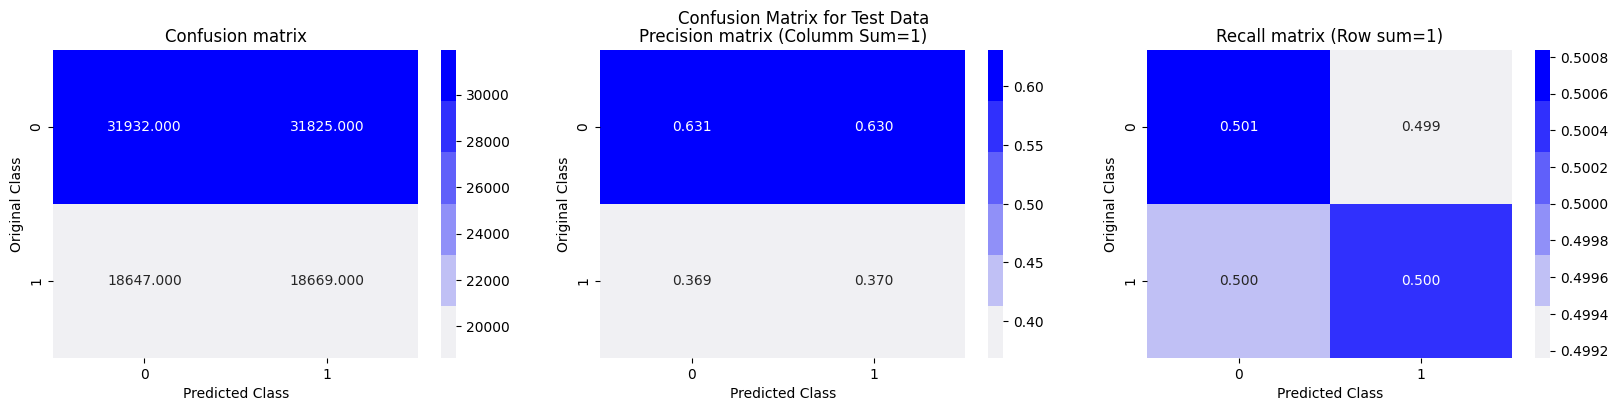

In [9]:
# Build a random classifier to get a base line for the log-loss to further compare with the ML models

y_pred = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    y_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, y_pred, eps=1e-15))

y_pred =np.argmax(y_pred, axis=1)
print_scores(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

### **4.2 Logistic Regression Model**

 12%|█▎        | 1/8 [00:34<04:03, 34.78s/it]

For values of alpha =  1e-05 The log loss is: 0.4863435555942172


 25%|██▌       | 2/8 [00:49<02:18, 23.02s/it]

For values of alpha =  0.0001 The log loss is: 0.48564878724642085


 38%|███▊      | 3/8 [01:05<01:39, 19.92s/it]

For values of alpha =  0.001 The log loss is: 0.48781553659652593


 50%|█████     | 4/8 [01:15<01:02, 15.74s/it]

For values of alpha =  0.01 The log loss is: 0.49840888669010336


 62%|██████▎   | 5/8 [01:21<00:37, 12.53s/it]

For values of alpha =  0.1 The log loss is: 0.5200892035769508


 75%|███████▌  | 6/8 [01:30<00:22, 11.13s/it]

For values of alpha =  1 The log loss is: 0.5453258627481519


 88%|████████▊ | 7/8 [01:37<00:09,  9.75s/it]

For values of alpha =  10 The log loss is: 0.5569811023664322


100%|██████████| 8/8 [01:45<00:00, 13.17s/it]

For values of alpha =  100 The log loss is: 0.5587525696262546


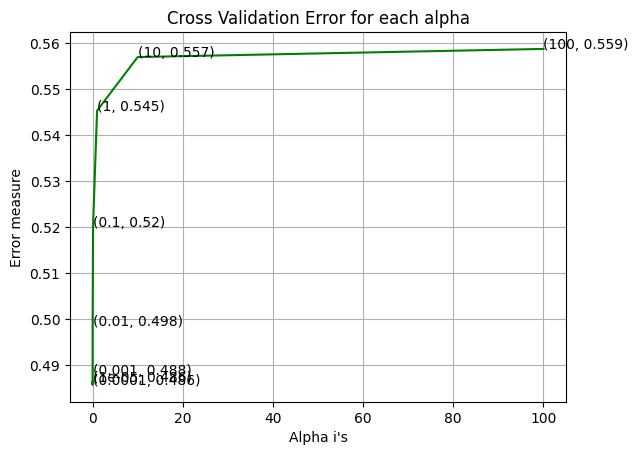

In [10]:
# hyperparam for SGD classifier

alpha = [10 ** x for x in range(-5, 3)]

log_error_array = []
for i in tqdm(alpha):
    
    clf = SGDClassifier(alpha=i, penalty = 'l2', loss = 'log',class_weight = 'balanced', random_state = 42)
    # since log-loss is calculated, we use calibrated classifier to calibrate the probabilities
    calibrated_clf = CalibratedClassifierCV(clf, method = "sigmoid", cv = 5)
    calibrated_clf.fit(x_train, y_train)

    y_pred = calibrated_clf.predict_proba(x_test)
    loss = log_loss(y_test, y_pred, eps = 1e-15)
    log_error_array.append(loss)

    print('For values of alpha = ', i, "The log loss is:",loss)

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, err in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(err,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.0001 The train log loss is: 0.4308140415275522
For values of best alpha =  0.0001 The test log loss is: 0.48564878724642085
Total number of data points : 101073
test accuracy  is 74.06%
precision score : 73.18%
Recall score : 46.96%
F1-score : 57.21%


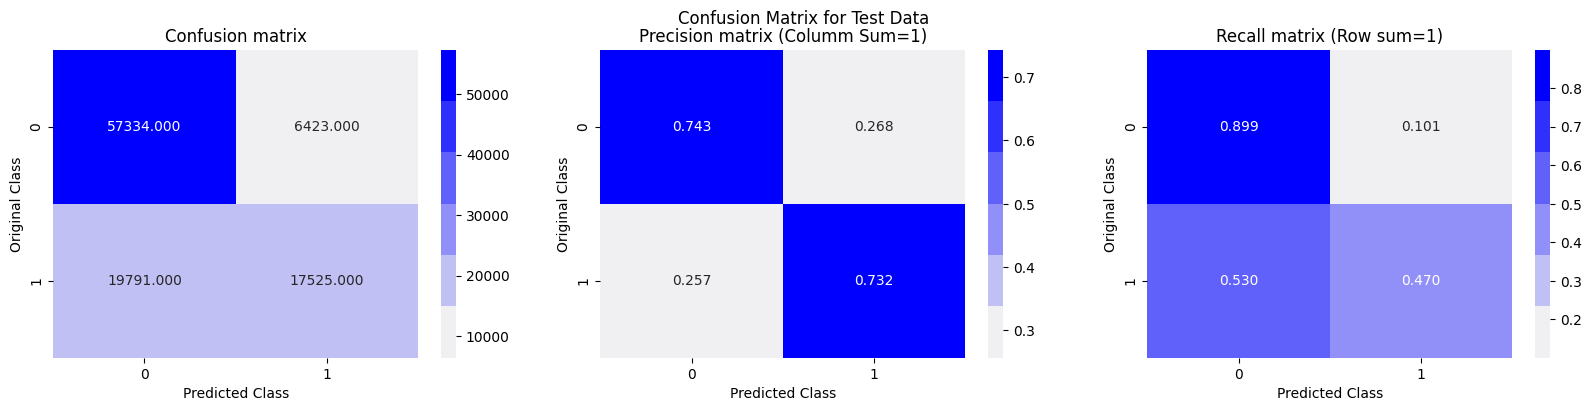

In [11]:
# Using the best hyper parameter and fit the model to the train data
best_alpha_idx = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha_idx], penalty='l2', loss='log', class_weight = 'balanced', random_state=42)
calibrated_clf = CalibratedClassifierCV(clf, method="sigmoid")
calibrated_clf.fit(x_train, y_train)

y_pred = calibrated_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha_idx], "The train log loss is:",log_loss(y_train, y_pred, labels= calibrated_clf.classes_, eps=1e-15))
y_pred = calibrated_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha_idx], "The test log loss is:",log_loss(y_test, y_pred, labels= calibrated_clf.classes_, eps=1e-15))
y_pred =np.argmax(y_pred,axis=1)  # To convert probabilities into classes
print("Total number of data points :", len(y_pred))
print_scores(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

### **4.3 Linear SVM Model**

 12%|█▎        | 1/8 [00:33<03:54, 33.44s/it]

For values of alpha =  1e-05 The log loss is: 0.4895896057404926


 25%|██▌       | 2/8 [00:49<02:20, 23.45s/it]

For values of alpha =  0.0001 The log loss is: 0.48776600508155676


 38%|███▊      | 3/8 [00:58<01:22, 16.50s/it]

For values of alpha =  0.001 The log loss is: 0.48863731033883584


 50%|█████     | 4/8 [01:06<00:52, 13.14s/it]

For values of alpha =  0.01 The log loss is: 0.49626131838726256


 62%|██████▎   | 5/8 [01:13<00:33, 11.09s/it]

For values of alpha =  0.1 The log loss is: 0.5157489121055295


 75%|███████▌  | 6/8 [01:24<00:22, 11.15s/it]

For values of alpha =  1 The log loss is: 0.5413182887405306


 88%|████████▊ | 7/8 [01:35<00:11, 11.14s/it]

For values of alpha =  10 The log loss is: 0.556040660224438


100%|██████████| 8/8 [01:44<00:00, 13.08s/it]

For values of alpha =  100 The log loss is: 0.558960525930319


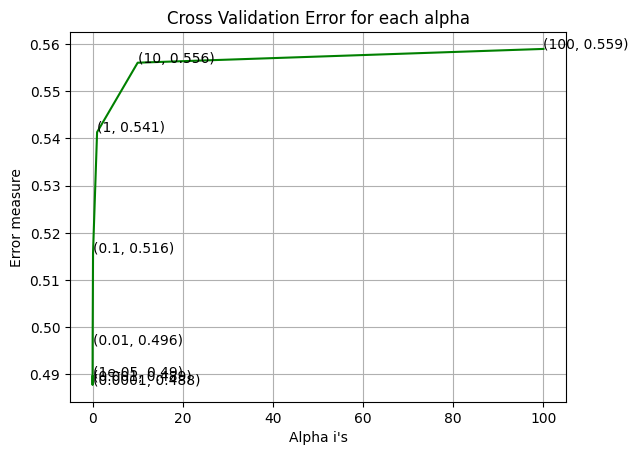

In [12]:
# hyperparam for SGD classifier
alpha = [10 ** x for x in range(-5, 3)]

log_error_array = []
for i in tqdm(alpha):
    
    # hinge loss ==> svm
    clf = SGDClassifier(alpha=i, penalty = 'l2', loss = 'hinge', class_weight = 'balanced', random_state = 42)

    calibrated_clf = CalibratedClassifierCV(clf, method = "sigmoid", cv = 5)
    calibrated_clf.fit(x_train, y_train)

    y_pred = calibrated_clf.predict_proba(x_test)
    loss = log_loss(y_test, y_pred, eps = 1e-15)
    log_error_array.append(loss)

    print('For values of alpha = ', i, "The log loss is:",loss)

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, err in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(err,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.0001 The train log loss is: 0.4362072194004222
For values of best alpha =  0.0001 The test log loss is: 0.4934118816679075
Total number of test data points : 101073
test accuracy  is 74.17%
precision score : 76.95%
Recall score : 42.86%
F1-score : 55.06%


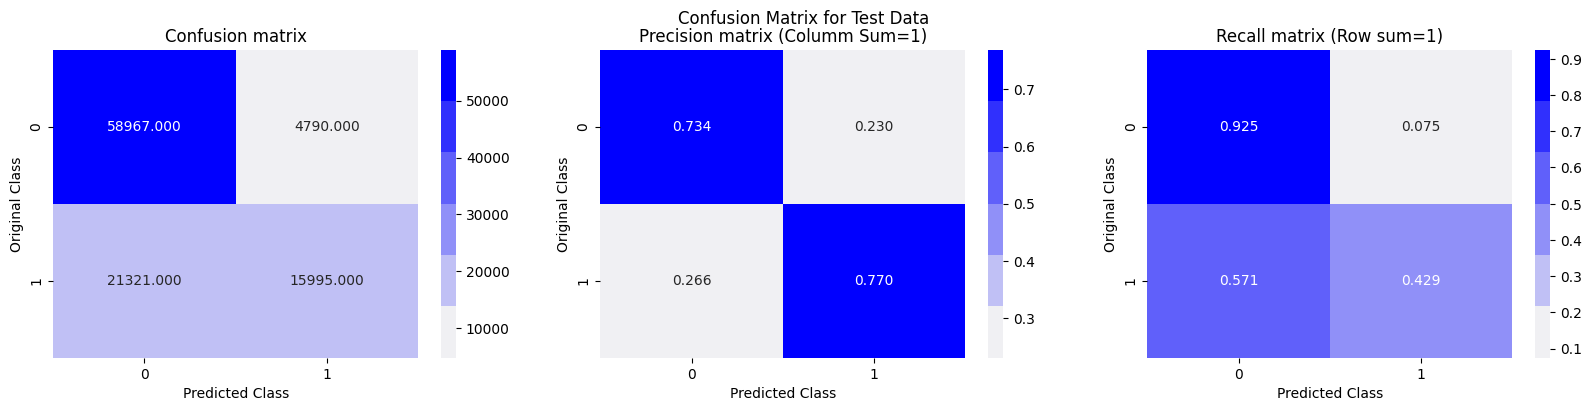

In [13]:
# Using the best hyper parameter and fit the model to the train data
best_alpha_idx = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha_idx], penalty='l2', loss='hinge', random_state=42)
calibrated_clf = CalibratedClassifierCV(clf, method="sigmoid")
calibrated_clf.fit(x_train, y_train)

y_pred = calibrated_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha_idx], "The train log loss is:",log_loss(y_train, y_pred, labels=calibrated_clf.classes_, eps=1e-15))
y_pred = calibrated_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha_idx], "The test log loss is:",log_loss(y_test, y_pred, labels=calibrated_clf.classes_, eps=1e-15))
y_pred =np.argmax(y_pred,axis=1)  # convert probabilities into classes
print("Total number of test data points :", len(y_pred))
print_scores(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

### **4.4 XGBOOST**

In [18]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric = "logloss", tree_method = "gpu_hist",
                        scale_pos_weight=0.37, subsample = 0.5, colsample_bytree = 0.7, seed=42)

param_grid = {'max_depth': [2, 4, 6],
              'n_estimators': [50, 100, 150]
             }

clf = RandomizedSearchCV(xgb_clf, param_distributions = param_grid, scoring = 'neg_log_loss', cv = 3, return_train_score=True, verbose=3, n_jobs=-1)
clf.fit(x_train, y_train)

# best scores given by the RandomSearchCV
print('Best Log_loss on Train Data: ',clf.best_score_)
print('Hyper Parameters value with best log_loss is ',clf.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Log_loss on Train Data:  -0.40405317150293335
Hyper Parameters value with best log_loss is  {'n_estimators': 150, 'max_depth': 6}


The train log loss is: 0.3112156251492341
The test log loss is: 0.42653156717970564
Total number of test data points : 101073
test accuracy  is 79.07%
precision score : 84.39%
Recall score : 53.15%
F1-score : 65.22%


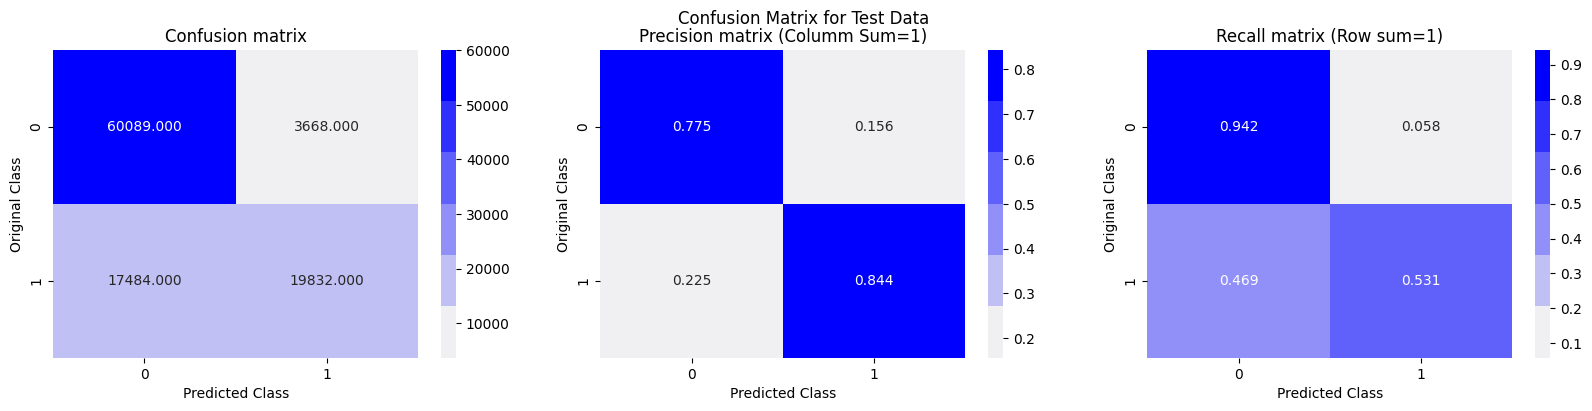

In [27]:
# load the best model
best_xgb_clf = xgb.XGBClassifier(**clf.best_params_, tree_method = "gpu_hist", scale_pos_weight=0.37, objective='binary:logistic', eval_metric = "logloss")
# perform calibration on the best model
calibrated_best_clf = CalibratedClassifierCV(best_xgb_clf, cv=5)
calibrated_best_clf.fit(x_train, y_train)

# Calculate the log loss on the train data and test data
y_pred = calibrated_best_clf.predict_proba(x_train)
print("The train log loss is:",log_loss(y_train, y_pred, labels=calibrated_best_clf.classes_, eps=1e-15))
y_pred = calibrated_best_clf.predict_proba(x_test)
print("The test log loss is:",log_loss(y_test, y_pred, labels=calibrated_best_clf.classes_, eps=1e-15))

# prediction of classes 
y_pred = calibrated_best_clf.predict_proba(x_test)  
print("Total number of test data points :", len(y_pred))
y_pred = (y_pred[:, 1] >= 0.5).astype(int)
# print scores and plot confusion matrix
print_scores(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

## **5. Results**

In [31]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model Name", "Log-Loss", "Accuracy Score", "F1-Score"]
x.add_row(["Random Model", 0.8904, 0.5006, 0.4252])
x.add_row(["Logistic Regression",  0.4856, 0.7406, 0.5721])
x.add_row(["Linear SVM", 0.4934, 0.7417, 0.5506])
x.add_row(["XGBoost", 0.4265, 0.7907, 0.6522])
print(x)

+---------------------+----------+----------------+----------+
|      Model Name     | Log-Loss | Accuracy Score | F1-Score |
+---------------------+----------+----------------+----------+
|     Random Model    |  0.8904  |     0.5006     |  0.4252  |
| Logistic Regression |  0.4856  |     0.7406     |  0.5721  |
|      Linear SVM     |  0.4934  |     0.7417     |  0.5506  |
|       XGBoost       |  0.4265  |     0.7907     |  0.6522  |
+---------------------+----------+----------------+----------+
